In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import time
import warnings
warnings.filterwarnings('ignore')
#set random seed for reproducibility
np.random.seed(42)

#Download NLTK resources

In [2]:
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

#Load Dataset

In [3]:
from google.colab import drive
#mount google drive
drive.mount('/content/drive')

#load dataset
df = pd.read_csv('/content/drive/MyDrive/ML_twitter_dataset/twitter.csv',
                 header=None,
                 names=['tweet_record_id', 'entity', 'sentiment', 'tweet_description'])

Mounted at /content/drive


In [4]:
#display basic info
print("\nDataset Information")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows of the dataset:")
print(df.head())


Dataset Information
Number of rows: 74682
Number of columns: 4

Column names:
['tweet_record_id', 'entity', 'sentiment', 'tweet_description']

First few rows of the dataset:
   tweet_record_id       entity sentiment  \
0             2401  Borderlands  Positive   
1             2401  Borderlands  Positive   
2             2401  Borderlands  Positive   
3             2401  Borderlands  Positive   
4             2401  Borderlands  Positive   

                                   tweet_description  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [5]:
#rename columns for clarity based on their content
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_text']

#display unique values in sentiment column
print("\nUnique sentiment values:")
print(df['sentiment'].unique())
print(f"Count of unique sentiment values: {df['sentiment'].nunique()}")
print("\nSentiment value counts:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


Unique sentiment values:
['Positive' 'Neutral' 'Negative' 'Irrelevant']
Count of unique sentiment values: 4

Sentiment value counts:
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


#Data Cleaning

In [ ]:
#check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

#remove duplicates if any
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows. New shape: {df.shape}")

#check for and handle missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

if missing_values > 0:
    #fill missing values or drop rows with missing values
    df = df.dropna()
    print(f"Removed rows with missing values. New shape: {df.shape}")

#function to clean data
def clean_text(text):
    """Clean and preprocess text data"""
    # Check if the input is a string
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

Number of duplicate rows: 2700
Removed 2700 duplicate rows. New shape: (71982, 4)
Total missing values: 326
Removed rows with missing values. New shape: (71656, 4)


In [7]:
#apply cleaning function to tweet text
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

#display some examples of original and cleaned text
print("\nExamples of original and cleaned text:")
for i in range(5):
    print(f"\nOriginal: {df['tweet_text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")

empty_text_count = (df['cleaned_text'] == '').sum()
if empty_text_count > 0:
    print(f"Found {empty_text_count} rows with empty cleaned text. Removing them...")
    df = df[df['cleaned_text'] != '']
    print(f"New shape after removing empty text: {df.shape}")

#check the distribution of sentiments after cleaning
print("\nSentiment distribution after cleaning")
sentiment_distribution = df['sentiment'].value_counts()
print(sentiment_distribution)

#encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

#display the mapping of encodings
print("\nSentiment encoding mapping")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Examples of original and cleaned text:

Original: im getting on borderlands and i will murder you all ,
Cleaned: im getting borderland murder

Original: I am coming to the borders and I will kill you all,
Cleaned: coming border kill

Original: im getting on borderlands and i will kill you all,
Cleaned: im getting borderland kill

Original: im coming on borderlands and i will murder you all,
Cleaned: im coming borderland murder

Original: im getting on borderlands 2 and i will murder you me all,
Cleaned: im getting borderland murder
Found 1642 rows with empty cleaned text. Removing them...
New shape after removing empty text: (70014, 5)

Sentiment distribution after cleaning
sentiment
Negative      21254
Positive      19223
Neutral       17254
Irrelevant    12283
Name: count, dtype: int64

Sentiment encoding mapping
Irrelevant: 0
Negative: 1
Neutral: 2
Positive: 3


#Feature extraction

In [8]:
#extract features using TF-IDF
print("Applying TF-IDF vectorization")
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment_encoded']

# Display the shape of the feature matrix
print(f"\nFeature matrix shape: {X.shape}")

Applying TF-IDF vectorization

Feature matrix shape: (70014, 5000)


#Split Data

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (56011, 5000)
Validation set shape: (14003, 5000)


#Build model and evaluate

In [10]:
#SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
model_training_start = time.time()
svm_model.fit(X_train, y_train)

print("\nEvaluating model on training data")
y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on validation data
print("Evaluating model on validation data")
y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

#classification report for validation data
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))


Evaluating model on training data
Training Accuracy: 0.7786
Evaluating model on validation data
Validation Accuracy: 0.7196

Classification Report (Validation):
              precision    recall  f1-score   support

  Irrelevant       0.67      0.58      0.62      2456
    Negative       0.73      0.81      0.77      4251
     Neutral       0.74      0.66      0.70      3451
    Positive       0.72      0.76      0.74      3845

    accuracy                           0.72     14003
   macro avg       0.71      0.70      0.71     14003
weighted avg       0.72      0.72      0.72     14003



In [13]:
#compute precision, recall, and F1-score for training and validation
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

#Confusion matrix

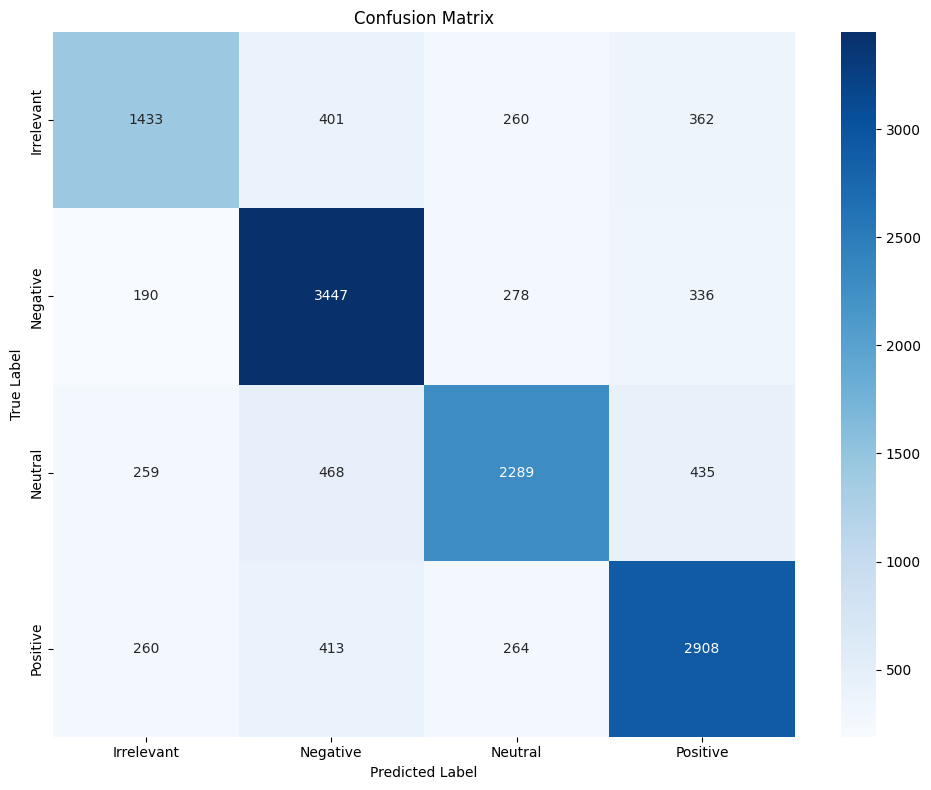

In [14]:
#create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

#plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

#Summary

In [15]:
#final summary
print("\nSummary")
print(f"Dataset Size: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Sentiment Classes: {', '.join(label_encoder.classes_)}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

print(f"\n- Training Accuracy: {train_accuracy:.4f}")
print(f"\n- Validation Accuracy: {val_accuracy:.4f}")


Summary
Dataset Size: 70014 rows, 6 columns
Sentiment Classes: Irrelevant, Negative, Neutral, Positive
Training Precision: 0.7788
Validation Precision: 0.7187
Training Recall: 0.7786
Validation Recall: 0.7196
Training F1-score: 0.7770
Validation F1-score: 0.7174

- Training Accuracy: 0.7786

- Validation Accuracy: 0.7196
